In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [ ]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Using device: mps


In [ ]:
# Define transformation for data preprocessing
transform = transforms.Compose([
    transforms.Resize(size=(64, 64)), #consistent input dimensions accross datasets
    transforms.ToTensor(), #tensor is the fundamental data structure used in PyTorch for representing and manipulating multi-dimensional arrays
])

In [ ]:
# Load the TESS dataset
#ImageFolder : load image data from a directory structure and organize it into a dataset
#transform parameter : specify the transformation pipeline
dataset = ImageFolder("/Users/vishnuhonnavalli/Desktop/ravdess_tess/", transform=transform)

In [ ]:
# Split the dataset into training, validation, and testing sets
#Random splitting ensures that the training set is diverse and representative of the entire dataset, allowing the model to learn patterns and generalize well to unseen data.
#Random splitting ensures that the validation set is independent of the training set and provides an unbiased estimate of the model's performance.

train_size = int(0.8 * len(dataset))
#val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [ ]:
# Create data loaders
# DataLoader : loading data from a dataset in batches for efficient processing during training
# Batch Size : number of samples processed together in each iteration of model training
# 32 : is typically small enough to fit within the memory of modern GPUs, allowing for efficient parallel processing, while also being large enough to provide a reasonable amount of computational acceleration compared to smaller batch sizes.
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers):
        super(DenseBlock, self).__init__()
        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            self.layers.append(self._make_layer(in_channels, growth_rate))
            in_channels += growth_rate

    def _make_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        )

    def forward(self, x):
        features = [x]
        for layer in self.layers:
            new_features = layer(x)
            features.append(new_features)
            x = torch.cat(features, dim=1)
        return x

class TransitionBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = F.relu(x)
        x = self.conv(x)
        x = self.pool(x)
        return x

class DenseNet(nn.Module):
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16), num_classes=7):
        super(DenseNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        in_channels = 64
        for i, num_layers in enumerate(block_config):
            block = DenseBlock(in_channels, growth_rate, num_layers)
            self.features.add_module(f"dense_block_{i + 1}", block)
            in_channels += num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = TransitionBlock(in_channels, in_channels // 2)
                self.features.add_module(f"transition_block_{i + 1}", trans)
                in_channels = in_channels // 2

        self.features.add_module("norm5", nn.BatchNorm2d(in_channels))
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(in_channels, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
# Usage example
input_shape = (3, 224, 224)
num_classes = 7
model = DenseNet(num_classes=num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the optimizer and learning rate scheduler
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
# Train the model
num_epochs = 100
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
best_test_accuracy = 0.0

for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss = 0.0
    train_correct = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images).to(device)
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()

        loss = criterion(outputs, labels)
        train_loss += loss.item() * images.size(0)

        loss.backward()
        optimizer.step()

    train_loss /= len(train_dataset)
    train_accuracy = train_correct / len(train_dataset)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    test_loss = 0.0
    test_correct = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_correct += (predicted == labels).sum().item()

            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)

    test_loss /= len(test_dataset)
    test_accuracy = test_correct / len(test_dataset)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    # Print training and test accuracy
    if(epoch==0 or (epoch+1)%5==0):
      print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.4f}')


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100] - Train Loss: 1.4678 - Train Accuracy: 0.4198 - Test Loss: 4.3233 - Test Accuracy: 0.3515
Epoch [5/100] - Train Loss: 0.6883 - Train Accuracy: 0.7488 - Test Loss: 1.2797 - Test Accuracy: 0.6258
Epoch [10/100] - Train Loss: 0.4914 - Train Accuracy: 0.8244 - Test Loss: 1.4024 - Test Accuracy: 0.5853
Epoch [15/100] - Train Loss: 0.3943 - Train Accuracy: 0.8570 - Test Loss: 0.6716 - Test Accuracy: 0.7699
Epoch [20/100] - Train Loss: 0.3160 - Train Accuracy: 0.8826 - Test Loss: 0.9500 - Test Accuracy: 0.7231
Epoch [25/100] - Train Loss: 0.2366 - Train Accuracy: 0.9136 - Test Loss: 0.2960 - Test Accuracy: 0.8850
Epoch [30/100] - Train Loss: 0.1787 - Train Accuracy: 0.9332 - Test Loss: 0.3979 - Test Accuracy: 0.8559
Epoch [35/100] - Train Loss: 0.1374 - Train Accuracy: 0.9446 - Test Loss: 0.3837 - Test Accuracy: 0.8761
Epoch [40/100] - Train Loss: 0.1197 - Train Accuracy: 0.9541 - Test Loss: 0.3837 - Test Accuracy: 0.8723
Epoch [45/100] - Train Loss: 0.0863 - Train Accuracy: 0.9

In [ ]:
# Save the model if test accuracy improves
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
    torch.save(model.state_dict(), 'best_model.pt')

# Load the best model
model.load_state_dict(torch.load('best_model.pt'))

# Evaluate the model on test data
test_correct = 0
model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_correct += (predicted == labels).sum().item()

test_accuracy = test_correct / len(test_dataset)
print('Test Accuracy:', test_accuracy)

Test Accuracy: 0.9102402022756005


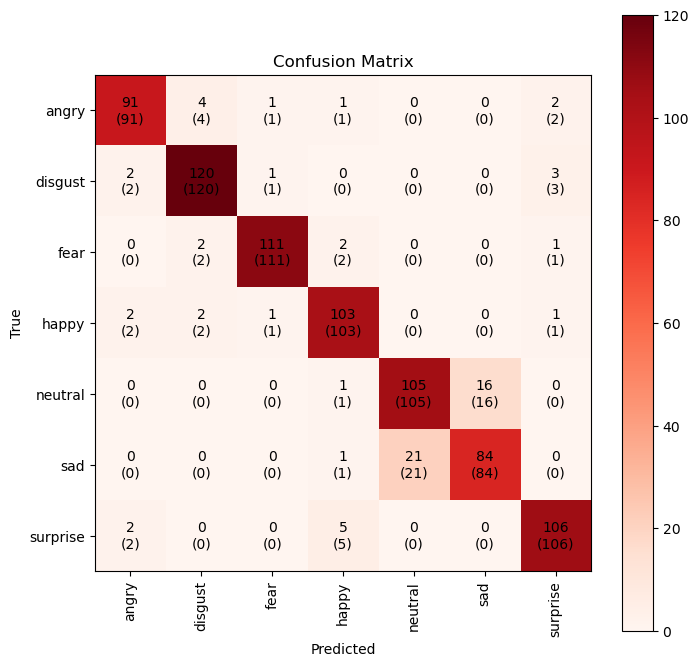

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,classification_report


# Compute the confusion matrix and correctly predicted counts
model.eval()
test_predictions = []
test_targets = []
correct_counts = np.zeros((len(dataset.classes), len(dataset.classes)), dtype=int)

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        test_predictions.extend(predicted.cpu().numpy())
        test_targets.extend(labels.cpu().numpy())

        for pred, target in zip(predicted, labels):
            correct_counts[target.item(), pred.item()] += 1

confusion_mat = confusion_matrix(test_targets, test_predictions)

# Visualize the confusion matrix with correct counts
plt.figure(figsize=(8, 8))
plt.imshow(confusion_mat, cmap='Reds')

# Add correct counts to each cell
for i in range(len(dataset.classes)):
    for j in range(len(dataset.classes)):
        plt.text(j, i, f"{confusion_mat[i, j]}\n({correct_counts[i, j]})", ha='center', va='center', color='black')

plt.colorbar()
plt.xticks(np.arange(len(dataset.classes)), dataset.classes, rotation=90)
plt.yticks(np.arange(len(dataset.classes)), dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
report = classification_report(test_targets, test_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.94      0.92      0.93        99
           1       0.94      0.95      0.94       126
           2       0.97      0.96      0.97       116
           3       0.91      0.94      0.93       109
           4       0.83      0.86      0.85       122
           5       0.84      0.79      0.82       106
           6       0.94      0.94      0.94       113

    accuracy                           0.91       791
   macro avg       0.91      0.91      0.91       791
weighted avg       0.91      0.91      0.91       791



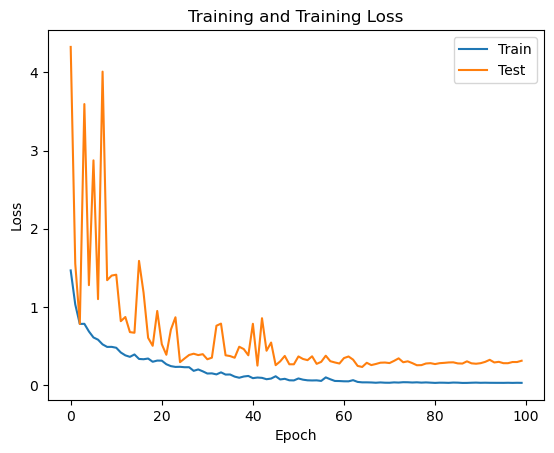

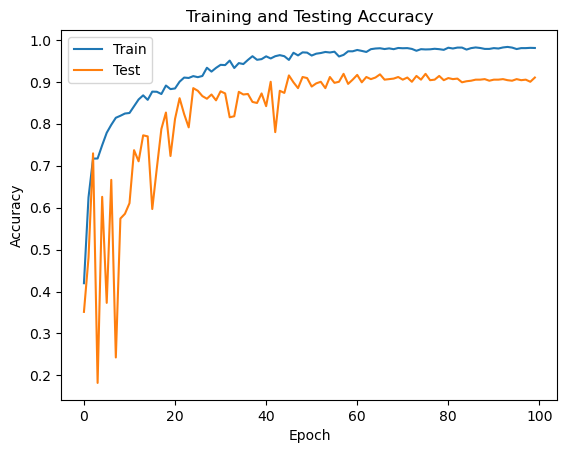

In [ ]:
# Plot training and validation losses
plt.figure()
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Training Loss')
plt.legend()
plt.show()

# Plot training and validation accuracies
plt.figure()
plt.plot(train_accuracies, label='Train')
plt.plot(test_accuracies, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()
plt.show()

In [ ]:
#!pip install --force-reinstall numpy==1.23.5